# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Add path .. to make relative import

In [2]:
import sys

sys.path.insert(0, '..')

# Import libraries

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from src.preparation.reading import *
from src.processing.standardization import standardize_image
from src.processing.preprocessing import preproc_image
from src.processing.mask_and_contour import get_mask
from pandas import DataFrame

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

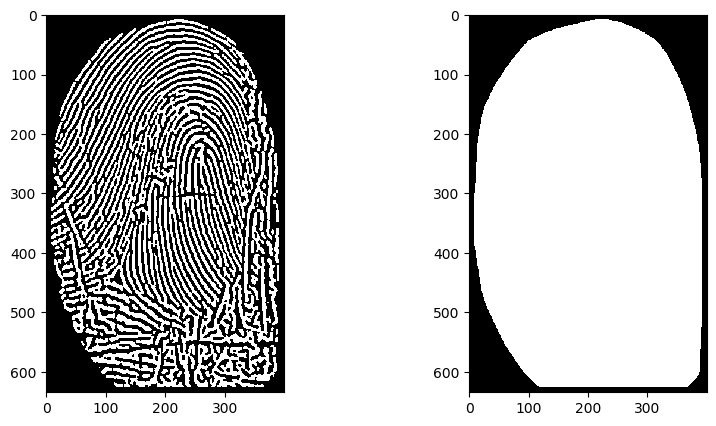

In [4]:
im = read_random_image(RAW_FILE_PATH_GOODIM)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)
mask = get_mask(prep_im, with_ench=False) == 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(prep_im)
ax2.imshow(mask)
plt.show()

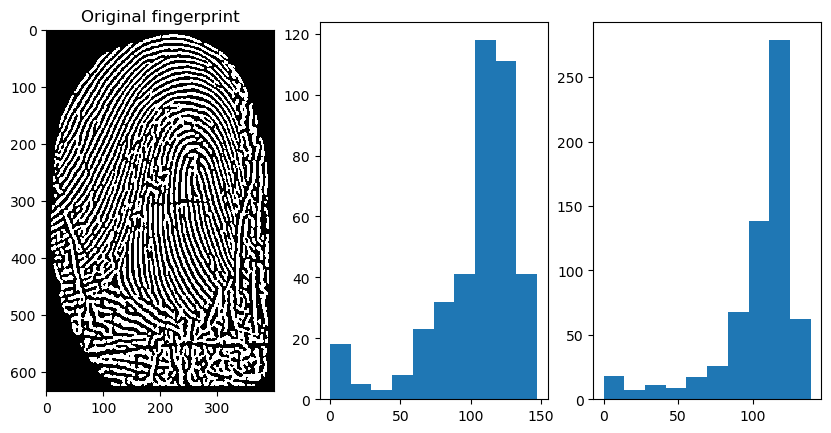

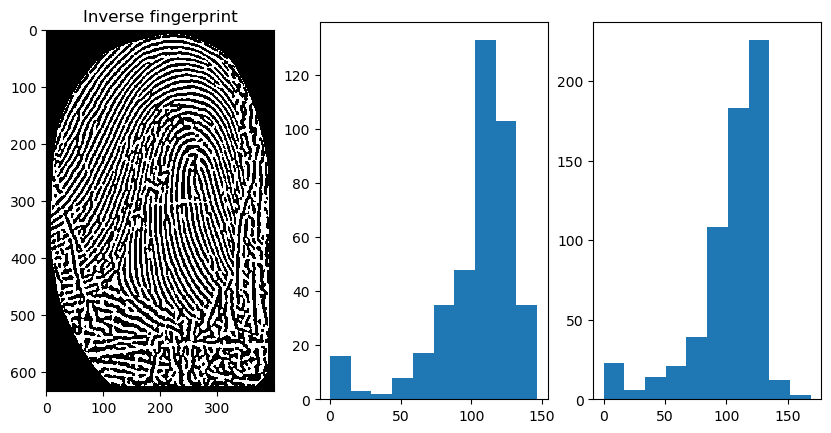

In [5]:
inv_im = cv.bitwise_not(prep_im)
inv_im[mask ==False] = 0

orig_v_sum, orig_h_sum = prep_im.mean(axis=0), prep_im.mean(axis=1)
inv_v_sum, inv_h_sum = inv_im.mean(axis=0), inv_im.mean(axis=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.imshow(prep_im)
ax1.set_title("Original fingerprint")
ax2.hist(orig_v_sum)
ax3.hist(orig_h_sum)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.imshow(inv_im)
ax1.set_title("Inverse fingerprint")
ax2.hist(inv_v_sum)
ax3.hist(inv_h_sum)
plt.show()

In [6]:
def get_horizontal_vertical_mean_percentiles(im, percs=[30, 60, 90, 100]):
    result = np.array([])
    mask = get_mask(im, with_ench=False)
    
    inv_im = cv.bitwise_not(im)
    inv_im[mask ==False] = 0

    orig_v_sum = np.percentile(im.mean(axis=0), percs)
    orig_h_sum = np.percentile(im.mean(axis=1), percs)
    inv_v_sum = np.percentile(inv_im.mean(axis=0), percs) 
    inv_h_sum = np.percentile(inv_im.mean(axis=1), percs)
    result = np.append(result, [orig_h_sum, orig_v_sum, inv_h_sum, inv_v_sum])
    
    return result

In [7]:
get_horizontal_vertical_mean_percentiles(prep_im)

array([102.        , 116.025     , 124.95      , 138.975     ,
        99.99212598, 116.85826772, 132.96141732, 147.37795276,
        98.175     , 117.3       , 127.5       , 168.9375    ,
       101.47795276, 115.2519685 , 130.5519685 , 146.57480315])

# Use Linear SVC for image classification

## Function for getting data

In [8]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = get_horizontal_vertical_mean_percentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [9]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_HOLES, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,97.5375,115.3875,133.8750,168.9375,103.355072,117.850242,125.652174,131.811594,100.08750,118.5750,134.5125,189.9750,108.693237,121.135266,128.526570,137.971014
1,94.3500,113.4750,131.3250,180.4125,101.022364,116.094249,124.648562,131.980831,96.58125,117.3000,136.4250,166.3875,100.207668,117.723642,125.463259,138.498403
2,96.9000,114.1125,131.3250,165.1125,98.817734,115.566502,127.290640,138.177340,96.51750,116.6625,134.5125,161.9250,102.628079,115.985222,126.871921,138.596059
3,97.5375,111.5625,123.0375,172.7625,100.636792,115.632075,127.500000,139.127358,101.68125,114.1125,130.0500,235.8750,101.839623,116.674528,128.702830,154.363208
4,95.6250,110.9250,126.2250,150.4500,97.462205,116.456693,126.094488,139.748031,95.62500,111.5625,125.5875,198.2625,100.273228,117.259843,126.496063,137.740157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,102.0000,116.6625,130.0500,170.2125,100.078493,116.891680,131.302983,158.124019,107.10000,124.9500,139.6125,201.4500,107.284144,122.496075,138.508634,162.927786
59,97.6650,115.3875,129.4125,148.5375,99.188976,118.625197,134.527559,154.606299,106.46250,119.8500,131.3250,151.0875,105.614173,118.062992,134.166142,150.188976
60,49.7250,60.5625,81.6000,97.5375,35.740157,59.433071,108.425197,135.732283,136.04250,181.6875,199.2825,216.1125,115.251969,188.338583,227.331496,236.125984
61,81.6000,93.7125,106.9725,130.6875,72.390995,100.710900,126.492891,161.137441,130.68750,144.0750,159.3750,194.4375,110.258294,136.966825,198.279621,215.924171


## Train LinearSVC and get

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=5000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()

## There is no mistake predictions